<a href="https://colab.research.google.com/github/ludoveltz/hackaton_projet_W3D5/blob/main/ADN_generator_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q spacy==3.8.4
!python -m spacy download fr_core_news_md
!pip install -q transformers torch sentence-transformers seaborn networkx PyPDF2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 52.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import spacy
import re
from PyPDF2 import PdfReader
import io
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [2]:
try:
    nlp = spacy.load('fr_core_news_md')
    print("✅ SpaCy modèle français chargé avec succès")
except Exception as e:
    print(f"❌ Erreur lors du chargement du modèle SpaCy : {str(e)}")


✅ SpaCy modèle français chargé avec succès


In [31]:
from datetime import datetime

class BrandDNAAnalyzer:
    def __init__(self):
        print("🔄 Initialisation du système d'analyse...")

        # Chargement du modèle SpaCy avec gestion d'erreurs
        try:
            self.nlp = spacy.load('fr_core_news_md')
        except OSError:
            print("⚠️ Installation du modèle français...")
            import subprocess
            subprocess.run(['python', '-m', 'spacy', 'download', 'fr_core_news_md'])
            self.nlp = spacy.load('fr_core_news_md')

        # Modèles d'analyse
        self.sentiment_analyzer = pipeline('sentiment-analysis',
                                        model='nlptown/bert-base-multilingual-uncased-sentiment',
                                        truncation=True)
        self.sentence_model = SentenceTransformer('distiluse-base-multilingual-cased')

        # Taxonomie luxe
        self.luxury_taxonomy = {
            'materiaux_nobles': [
                'cuir', 'veau', 'taurillon', 'toile', 'métal', 'laiton',
                'palladium', 'textile', 'soie', 'canvas', 'microfibre'
            ],
            'savoir_faire': [
                'couture', 'artisanal', 'fait main', 'sur mesure',
                'assemblage', 'finition', 'confection', 'façonné'
            ],
            'heritage': [
                'maison', 'tradition', 'archive', 'signature', 'emblématique',
                'iconique', 'patrimoine', 'héritage', 'historique'
            ],
            'innovation': [
                'contemporain', 'moderne', 'technique', 'technologique',
                'innovant', 'intelligent', 'modulable', 'nanotechnologie'
            ],
            'design': [
                'motif', 'structure', 'ligne', 'silhouette', 'proportion',
                'harmonie', 'pattern', 'graphique'
            ]
        }

        print("✅ Système initialisé")

    def extract_text_from_pdfs(self, pdf_files):
        """Extrait et prétraite le texte des PDFs"""
        texts = []
        for filename, content in pdf_files.items():
            try:
                reader = PdfReader(io.BytesIO(content))
                text = " ".join([page.extract_text() for page in reader.pages])
                text = re.sub(r'\s+', ' ', text)
                text = text.replace('\n', ' ').strip()
                texts.append(text)
            except Exception as e:
                print(f"⚠️ Erreur lors de la lecture de {filename}: {str(e)}")
        return texts

    def preprocess_text(self, text):
        """Prétraitement du texte"""
        doc = self.nlp(text.lower())
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        return " ".join(tokens)

    def extract_price_range(self, texts):
        prices = []
        # Amélioration du pattern pour mieux détecter les prix
        pattern = r'(\d{1,4}(?:\s*\d{3})*)[,\s]*00?\s*€'

        for text in texts:
            if matches := re.findall(pattern, text):
                for match in matches:
                    try:
                        # Nettoyage et conversion plus robuste
                        price_str = match.replace(' ', '')
                        price = float(price_str)
                        if 100 <= price <= 10000:  # Filtre des prix réalistes
                            prices.append(price)
                    except ValueError:
                        continue

        if prices:
            return {
                'min': min(prices),
                'max': max(prices),
                'moyenne': np.mean(prices),
                'médiane': np.median(prices),
                'segments': {
                    'entrée de gamme': len([p for p in prices if p < 500]),
                    'milieu de gamme': len([p for p in prices if 500 <= p < 1500]),
                    'haut de gamme': len([p for p in prices if p >= 1500])
                }
            }
        return None

    def analyze_materials(self, texts):
        """Analyse des matériaux et finitions"""
        materials = []
        for text in texts:
            doc = self.nlp(text.lower())
            for token in doc:
                if any(mat in token.text for mat in self.luxury_taxonomy['materiaux_nobles']):
                    materials.append(token.text)
        return Counter(materials)

    def extract_key_features(self, texts):
        features = []
        key_patterns = [
            r"(?:^|[.!?]\s+)([^.!?]*(?:signature|emblématique|exclusif|unique)[^.!?]*[.!?])",
            r"(?:^|[.!?]\s+)([^.!?]*(?:collection|édition|série)[^.!?]*[.!?])",
            r"(?:^|[.!?]\s+)([^.!?]*(?:design|style|esthétique)[^.!?]*[.!?])"
        ]

        for text in texts:
            for pattern in key_patterns:
                matches = re.finditer(pattern, text, re.IGNORECASE)
                for match in matches:
                    feature = match.group(1).strip()
                    if 10 < len(feature) < 150:  # Filtrage par longueur
                        features.append(feature)

        # Dédoublonnage et tri par pertinence
        return list(set(features))

    def analyze_luxury_markers(self, text):
        """Analyse les marqueurs de luxe dans le texte"""
        markers = {category: [] for category in self.luxury_taxonomy.keys()}
        doc = self.nlp(text.lower())

        for category, terms in self.luxury_taxonomy.items():
            for term in terms:
                if term.lower() in text.lower():
                    context = self.get_context(text, term)
                    if context:
                        markers[category].append({
                            'term': term,
                            'context': context
                        })
        return markers

    def get_context(self, text, keyword, window=50):
        """Extrait le contexte autour d'un mot-clé"""
        index = text.lower().find(keyword.lower())
        if index != -1:
            start = max(0, index - window)
            end = min(len(text), index + len(keyword) + window)
            context = text[start:end].strip()
            context = re.sub(r'\s+', ' ', context)
            return context
        return None

    def analyze_visual_codes(self, texts):
        """Analyse des codes visuels distinctifs"""
        visual_codes = {
            'proportions': ['carré', 'rectangle', 'rond', 'ovale', 'géométrique'],
            'motifs': ['monogram', 'damier', 'rayures', 'logo', 'pattern', 'signature'],
            'finitions': ['mat', 'brillant', 'verni', 'grainé', 'lisse', 'texturé'],
            'couleurs': ['noir', 'blanc', 'or', 'argent', 'naturel', 'métallisé'],
            'techniques': ['surpiqûre', 'assemblage', 'couture', 'broderie', 'gravure']
        }

        codes_found = {category: [] for category in visual_codes}
        for text in texts:
            for category, elements in visual_codes.items():
                for element in elements:
                    if element in text.lower():
                        context = self.get_context(text, element)
                        if context:
                            codes_found[category].append({
                                'element': element,
                                'context': context
                            })
        return codes_found

    def analyze_innovation(self, texts):
        """Analyse des aspects innovants"""
        innovation_markers = {
            'technologie': ['technique', 'technologique', 'innovation', 'moderne', 'nouveau'],
            'matériaux': ['composite', 'technique', 'innovant', 'durable', 'recyclé'],
            'processus': ['développement', 'recherche', 'création', 'conception', 'élaboration'],
            'expérience': ['interactif', 'digital', 'connecté', 'intelligent', 'personnalisé']
        }

        innovation_score = 0
        innovation_details = {category: [] for category in innovation_markers}

        for text in texts:
            for category, markers in innovation_markers.items():
                for marker in markers:
                    if marker in text.lower():
                        context = self.get_context(text, marker)
                        if context:
                            innovation_score += 1
                            innovation_details[category].append({
                                'marker': marker,
                                'context': context
                            })

        return {
            'score': innovation_score / (len(texts) * len(innovation_markers)),
            'details': innovation_details
        }

    def analyze_heritage(self, texts):
        """Analyse de l'héritage et de la tradition"""
        heritage_markers = {
            'histoire': ['maison', 'tradition', 'héritage'],
            'savoir_faire': ['artisanat', 'expertise', 'métier', 'excellence'],
            'références': ['signature', 'emblématique', 'iconique', 'classique'],
            'valeurs': ['authenticité', 'qualité', 'excellence', 'prestige']
        }

        heritage_score = 0
        heritage_details = {category: [] for category in heritage_markers}

        for text in texts:
            for category, markers in heritage_markers.items():
                for marker in markers:
                    if marker in text.lower():
                        context = self.get_context(text, marker)
                        if context:
                            heritage_score += 1
                            heritage_details[category].append({
                                'marker': marker,
                                'context': context
                            })

        return {
            'score': heritage_score / (len(texts) * len(heritage_markers)),
            'details': heritage_details
        }

    def analyze_brand_dna(self, texts, filenames):
        """Analyse complète de l'ADN de la marque selon la méthodologie Solweig & Izar"""
        analysis = {
            'marqueurs_luxe': {},
            'signatures_visuelles': [],
            'elements_techniques': [],
            'positionnement_prix': self.extract_price_range(texts),
            'heritage_maison': [],
            'expertise_ai': {
                'workflows': [],
                'technologies': [],
                'innovations': []
            },
            'identite_creative': {
                'codes_visuels': [],
                'signatures': [],
                'storytelling': []
            }
        }

        # Analyse des marqueurs par catégorie
        for text in texts:
            markers = self.analyze_luxury_markers(text)
            for category, items in markers.items():
                if category not in analysis['marqueurs_luxe']:
                    analysis['marqueurs_luxe'][category] = []
                analysis['marqueurs_luxe'][category].extend(items)

        # Analyse approfondie
        analysis['codes_visuels'] = self.analyze_visual_codes(texts)
        analysis['innovation'] = self.analyze_innovation(texts)
        analysis['heritage'] = self.analyze_heritage(texts)

        # Analyse des aspects techniques et créatifs
        materials = self.analyze_materials(texts)
        key_features = self.extract_key_features(texts)

        # Analyse de l'expertise AI
        ai_expertise = {
            'workflows': ['dataset', 'normalisation', 'training', 'génératif'],
            'technologies': ['machine learning', 'vision par ordinateur', 'deep learning'],
            'innovations': ['hyperréalisme', 'fusion art-tech', 'préservation identité']
        }

        for text in texts:
            for category, terms in ai_expertise.items():
                found_terms = []
                for term in terms:
                    if term.lower() in text.lower():
                        found_terms.append(term)
                analysis['expertise_ai'][category].extend(found_terms)

        # Analyse identité créative
        creative_markers = {
            'codes_visuels': ['proportion', 'harmonie', 'technique', 'signature'],
            'signatures': ['timeless', 'impactful', 'luxe', 'innovation'],
            'storytelling': ['heritage', 'futur', 'artisanat', 'technologie']
        }

        for text in texts:
            for category, terms in creative_markers.items():
                found_terms = []
                for term in terms:
                    if term.lower() in text.lower():
                        found_terms.append(term)
                analysis['identite_creative'][category].extend(found_terms)

        # Analyse de similarité enrichie
        processed_texts = [self.preprocess_text(text) for text in texts]
        embeddings = self.sentence_model.encode(processed_texts)
        similarity_matrix = cosine_similarity(embeddings)

        # Conversion des arrays numpy en listes pour JSON
        similarity_matrix_list = similarity_matrix.tolist()

        # Analyse de similarité avec conversion pour JSON
        similarity_analysis = self.analyze_similarity_matrix(texts, filenames)
        if 'matrix' in similarity_analysis:
            similarity_analysis['matrix'] = similarity_analysis['matrix'].tolist()

        # Analyse des sentiments et perception
        sentiments = []
        for text in texts:
            # Limitation de la taille du texte pour l'analyse des sentiments
            sentiment = self.sentiment_analyzer(text[:512])[0]
            # Conversion du résultat en dict sérialisable
            sentiments.append({
                'label': sentiment['label'],
                'score': float(sentiment['score'])  # Conversion en float pour JSON
            })

        # Mise à jour finale de l'analyse avec données sérialisables
        analysis.update({
            'materials': dict(materials),
            'key_features': key_features,
            'similarity_analysis': similarity_analysis,
            'similarity_matrix': similarity_matrix_list,
            'sentiments': sentiments,
            'metadata': {
                'nombre_documents': len(texts),
                'date_analyse': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'version_modele': '2.0'
            }
        })

        # Génération du rapport de similarité
        similarity_report = self.generate_similarity_report(similarity_analysis)
        analysis['similarity_report'] = similarity_report

        return analysis



    def analyze_similarity_matrix(self, texts, filenames):
        """Analyse détaillée de la similarité entre documents"""
        processed_texts = [self.preprocess_text(text) for text in texts]
        embeddings = self.sentence_model.encode(processed_texts)
        similarity_matrix = cosine_similarity(embeddings)

        similarity_analysis = {
            'matrix': similarity_matrix,
            'document_pairs': [],
            'interpretation': {
                'très_forte': [],  # >0.8
                'forte': [],       # 0.6-0.8
                'moyenne': [],     # 0.4-0.6
                'faible': []       # <0.4
            }
        }

        # Analyse des paires de documents
        for i in range(len(texts)):
            for j in range(i+1, len(texts)):
                score = similarity_matrix[i][j]
                pair = {
                    'doc1': filenames[i],
                    'doc2': filenames[j],
                    'score': score,
                    'thèmes_communs': self.find_common_themes(texts[i], texts[j])
                }

                # Classification par niveau de similarité
                if score > 0.8:
                    similarity_analysis['interpretation']['très_forte'].append(pair)
                elif score > 0.6:
                    similarity_analysis['interpretation']['forte'].append(pair)
                elif score > 0.4:
                    similarity_analysis['interpretation']['moyenne'].append(pair)
                else:
                    similarity_analysis['interpretation']['faible'].append(pair)

        # Ajout de la visualisation de la matrice
        plt.figure(figsize=(12, 8))
        sns.heatmap(similarity_matrix,
                    cmap='RdYlBu_r',
                    xticklabels=[os.path.basename(f) for f in filenames],
                    yticklabels=[os.path.basename(f) for f in filenames],
                    annot=True,
                    fmt='.2f',
                    center=0.5)

        plt.title("Matrice de similarité des documents")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return similarity_analysis


    def find_common_themes(self, text1, text2):
        """Identifie les thèmes communs entre deux textes"""
        themes = []

        # Taxonomie enrichie basée sur l'ADN Solweig & Izar
        taxonomy = {
            'materiaux_nobles': [
                'cuir', 'toile', 'métal', 'veau', 'microfibre', 'soie',
                'textile', 'canvas', 'laiton', 'palladium'
            ],
            'savoir_faire': [
                'confection', 'artisanal', 'fait main', 'sur mesure',
                'assemblage', 'finition', 'façonné', 'couture'
            ],
            'heritage': [
                'emblématique', 'iconique', 'signature', 'maison',
                'tradition', 'archive', 'patrimoine', 'historique'
            ],
            'design': [
                'motif', 'pattern', 'ligne', 'silhouette', 'proportion',
                'harmonie', 'graphique', 'structure'
            ],
            'innovation_ai': [
                'intelligence artificielle', 'IA', 'génératif', 'dataset',
                'modèle', 'hyperréaliste', 'workflow', 'normalisation'
            ],
            'expertise_creative': [
                'direction artistique', 'concept', 'storytelling',
                'identité visuelle', 'ADN de marque', 'signature visuelle'
            ],
            'luxe': [
                'prestige', 'excellence', 'raffinement', 'élégance',
                'exclusif', 'premium', 'haute qualité'
            ]
        }

        # Analyse des catégories de la taxonomie
        for category, terms in taxonomy.items():
            common_terms = []
            for term in terms:
                if term in text1.lower() and term in text2.lower():
                    common_terms.append(term)

            if common_terms:
                themes.append({
                    'catégorie': category,
                    'termes': common_terms
                })

        return themes


    def generate_similarity_report(self, similarity_analysis):
        """Génère un rapport détaillé de la similarité"""
        report = []

        # En-tête
        report.append("\n🔍 SYNTHÈSE DES SIMILARITÉS:")

        # Vérification si nous avons des paires à analyser
        if 'interpretation' in similarity_analysis and any(similarity_analysis['interpretation'].values()):
            # Traitement des paires par niveau de similarité
            for niveau, pairs in similarity_analysis['interpretation'].items():
                if pairs:  # Si nous avons des paires pour ce niveau
                    report.append(f"\n• Similarité {niveau.replace('_', ' ')} ({len(pairs)} paires):")
                    for pair in pairs:
                        # Formatage du score en pourcentage
                        score_percentage = pair['score'] * 100
                        report.append(f"  - {pair['doc1']} × {pair['doc2']}: {score_percentage:.2f}%")

                        # Ajout des thèmes partagés s'ils existent
                        if pair['thèmes_communs']:
                            report.append("    Thèmes partagés:")
                            for theme in pair['thèmes_communs']:
                                report.append(f"    · {theme['catégorie']}: {', '.join(theme['termes'])}")
        else:
            report.append("\n• Aucune similarité significative trouvée entre les documents")

        return "\n".join(report)



    def generate_dna_report(self, analysis):
        """Génération du rapport d'analyse"""
        report = []
        report.append("\n🎨 ANALYSE ADN DE MARQUE")
        report.append("=====================")

        # Marqueurs distinctifs
        if analysis['marqueurs_luxe']:
            report.append("\n📍 MARQUEURS DISTINCTIFS")
            for category, markers in analysis['marqueurs_luxe'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_terms = set(m['term'] for m in markers)
                    for term in unique_terms:
                        report.append(f"  - {term}")

        # Section Codes Visuels
        if analysis.get('codes_visuels'):
            report.append("\n👁️ CODES VISUELS")
            for category, elements in analysis['codes_visuels'].items():
                if elements:
                    report.append(f"\n• {category.upper()}:")
                    unique_elements = set(e['element'] for e in elements)
                    for element in unique_elements:
                        report.append(f"  - {element}")

        # Section Innovation
        if analysis.get('innovation'):
            report.append("\n🚀 INNOVATION")
            report.append(f"• Score d'innovation: {analysis['innovation']['score']:.1%}")
            for category, markers in analysis['innovation']['details'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_markers = set(m['marker'] for m in markers)
                    for marker in unique_markers:
                        report.append(f"  - {marker}")

        # Nouvelle section Héritage
        if analysis.get('heritage'):
            report.append("\n📜 HÉRITAGE")
            report.append(f"• Score d'héritage: {analysis['heritage']['score']:.1%}")
            for category, markers in analysis['heritage']['details'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_markers = set(m['marker'] for m in markers)
                    for marker in unique_markers:
                        report.append(f"  - {marker}")

        # Analyse prix
        if analysis['positionnement_prix']:
            report.append("\n💰 POSITIONNEMENT PRIX")
            report.append(f"• Gamme: {analysis['positionnement_prix']['min']}€ - {analysis['positionnement_prix']['max']}€")
            report.append(f"• Moyenne: {analysis['positionnement_prix']['moyenne']:.2f}€")
            report.append("• Segmentation:")
            for segment, count in analysis['positionnement_prix']['segments'].items():
                report.append(f"  - {segment}: {count} produits")

        # Matériaux signatures
        if analysis['materials']:
            report.append("\n🎨 MATÉRIAUX SIGNATURES")
            for material, count in sorted(analysis['materials'].items(), key=lambda x: x[1], reverse=True)[:5]:
                report.append(f"• {material}: {count} mentions")

        # Caractéristiques distinctives
        if analysis['key_features']:
            report.append("\n✨ CARACTÉRISTIQUES DISTINCTIVES")
            key_features_sample = list(set(analysis['key_features']))[:5]
            for feature in key_features_sample:
                report.append(f"• {feature}")

        # Analyse des sentiments
        if analysis['sentiments']:
            positive_sentiments = len([s for s in analysis['sentiments'] if int(s['label'][0]) > 3])
            sentiment_ratio = positive_sentiments / len(analysis['sentiments'])
            report.append(f"\n🎯 PERCEPTION GÉNÉRALE")
            report.append(f"• Indice de prestige: {sentiment_ratio:.2%}")

        return "\n".join(report)

def analyze_brand_dna():
    """Fonction principale d'analyse"""
    from google.colab import files
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    analyzer = BrandDNAAnalyzer()

    print("\n📁 CHARGEMENT DES DOCUMENTS")
    print("========================")
    print("Veuillez sélectionner les fichiers PDF à analyser...")

    try:
        uploaded = files.upload()

        if not uploaded:
            print("❌ Aucun document uploadé")
            return

        filenames = list(uploaded.keys())
        print(f"\n✅ {len(uploaded)} document(s) chargé(s) avec succès:")
        for filename in filenames:
            print(f"  • {filename}")

        print(f"\n📊 ANALYSE EN COURS")
        print("=================")

        # Extraction du texte
        texts = analyzer.extract_text_from_pdfs(uploaded)

        if not texts:
            print("❌ Erreur: Impossible d'extraire le texte des documents")
            return

        # Analyse complète
        analysis = analyzer.analyze_brand_dna(texts, filenames)
        report = analyzer.generate_dna_report(analysis)

        # Affichage des rapports
        print("\n🧬 RAPPORT D'ANALYSE")
        print("==================")
        print(report)

        # Génération et affichage explicite de la synthèse des similarités
        if len(filenames) > 1:
            print("\n🔍 SYNTHÈSE DES SIMILARITÉS")
            print("========================")
            similarity_analysis = analyzer.analyze_similarity_matrix(texts, filenames)
            similarity_report = analyzer.generate_similarity_report(similarity_analysis)
            print(similarity_report)

            # Visualisation de la matrice
            plt.figure(figsize=(12, 8))
            similarity_matrix = similarity_analysis['matrix']

            sns.heatmap(similarity_matrix,
                       cmap='RdYlBu_r',
                       xticklabels=[os.path.basename(f) for f in filenames],
                       yticklabels=[os.path.basename(f) for f in filenames],
                       annot=True,
                       fmt='.2f',
                       center=0.5)

            plt.title("Matrice de similarité des documents")
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        else:
            print("\n📌 Note: La visualisation de similarité nécessite au moins deux documents.")

    except Exception as e:
        print(f"\n❌ Une erreur est survenue: {str(e)}")
        raise e



if __name__ == "__main__":
    print("✅ Système initialisé")



✅ Système initialisé


In [ ]:
!pip install -q faiss-cpu
!pip install -q sentence-transformers
!pip install -q transformers
!pip install -q rouge-score
!pip install -q nltk
!pip install -q PyPDF2


In [5]:
!pip install -q spacy
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


🔄 Initialisation du système Louis Vuitton DNA...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Device set to use cuda:0


📊 26 vecteurs chargés
✅ Système initialisé avec succès

🎨 SYSTÈME D'ANALYSE ADN LOUIS VUITTON
1. 📁 Analyser l'ADN de fiches produits
2. 📚 Analyser l'ADN de documents
3. 🔍 Recherche sémantique
4. ❌ Quitter

Choisissez une option (1-4): 1

📁 ANALYSE ADN FICHES PRODUITS


Saving Sac Slouchy MM.pdf to Sac Slouchy MM (8).pdf
Saving Pochette Accessoires.pdf to Pochette Accessoires (12).pdf
Saving Portefeuille chaŒne Rosy.pdf to Portefeuille chaŒne Rosy (10).pdf
🔄 Initialisation du système d'analyse...


Device set to use cuda:0


✅ Système initialisé


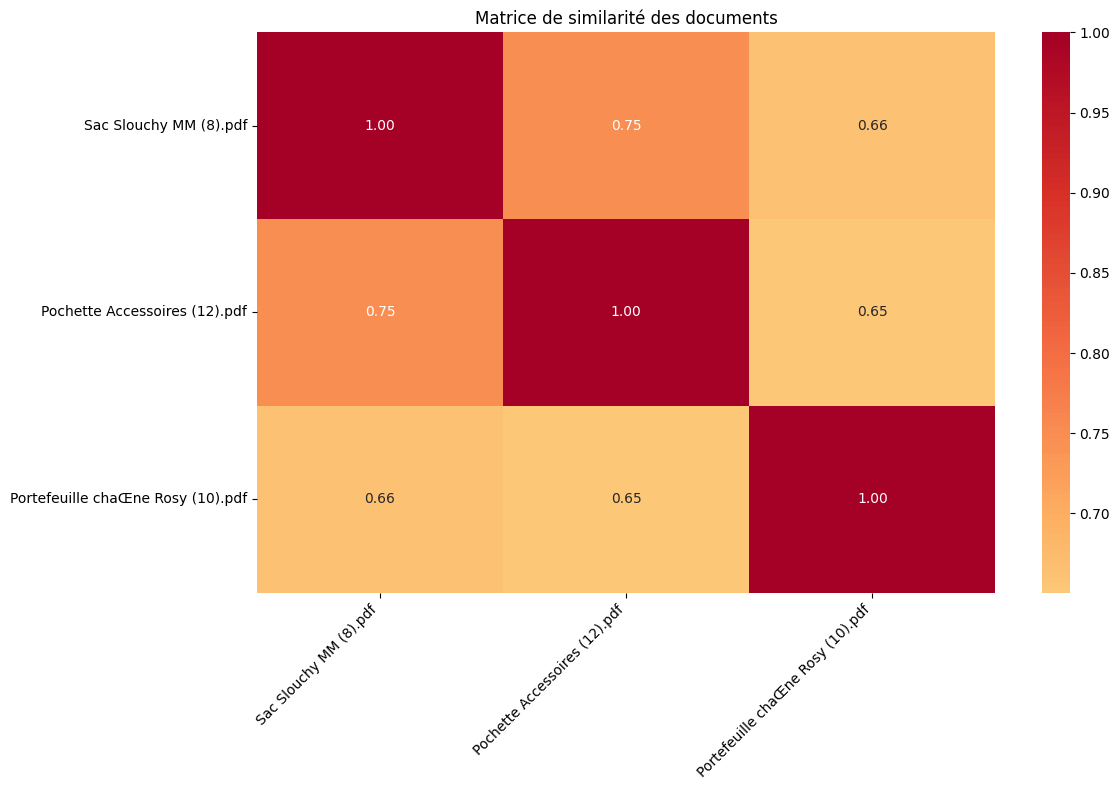

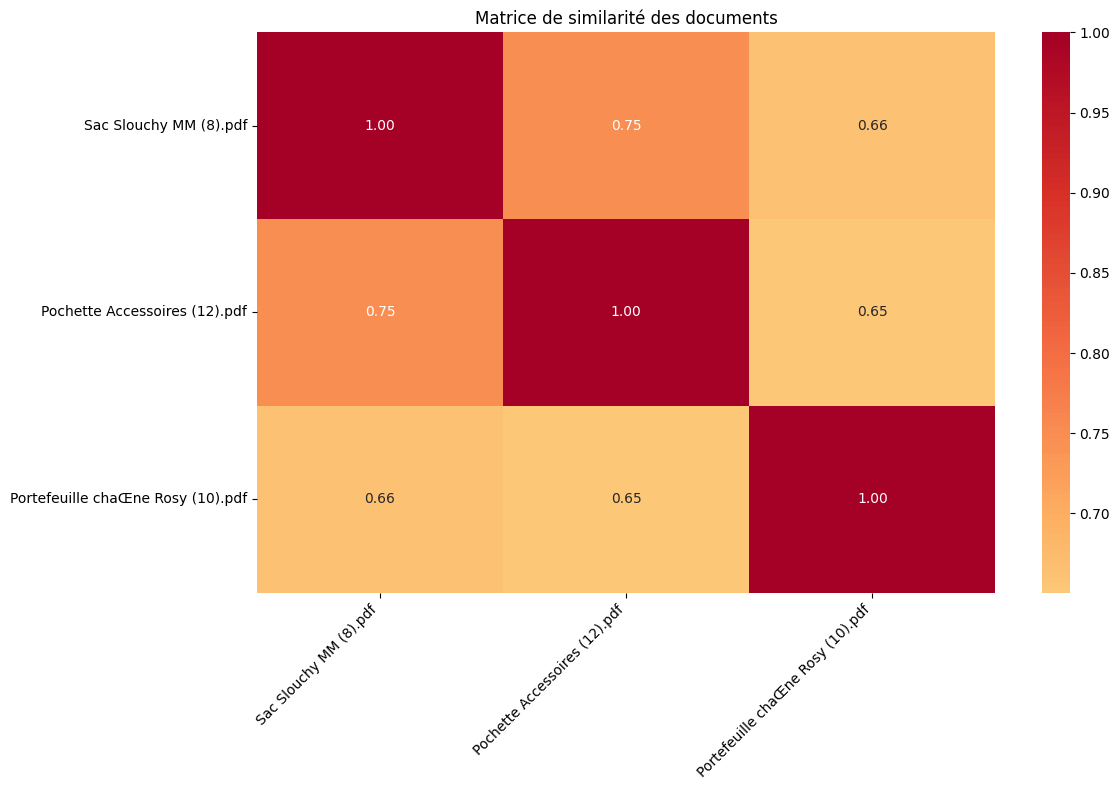


🔍 SYNTHÈSE DES SIMILARITÉS

🔍 SYNTHÈSE DES SIMILARITÉS:

• Similarité forte (3 paires):
  - Sac Slouchy MM (8).pdf × Pochette Accessoires (12).pdf: 74.62%
    Thèmes partagés:
    · materiaux_nobles: cuir, toile, métal
    · savoir_faire: confection
    · innovation_ai: modèle
  - Sac Slouchy MM (8).pdf × Portefeuille chaŒne Rosy (10).pdf: 66.36%
    Thèmes partagés:
    · materiaux_nobles: cuir, métal
    · savoir_faire: confection
    · heritage: maison
    · innovation_ai: modèle
  - Pochette Accessoires (12).pdf × Portefeuille chaŒne Rosy (10).pdf: 65.06%
    Thèmes partagés:
    · materiaux_nobles: cuir, métal
    · savoir_faire: confection
    · innovation_ai: modèle

🎨 ANALYSE ADN DE MARQUE

📍 MARQUEURS DISTINCTIFS

• MATERIAUX_NOBLES:
  - microfibre
  - métal
  - toile
  - cuir
  - canvas

• SAVOIR_FAIRE:
  - confection

• HERITAGE:
  - emblématique
  - maison

• DESIGN:
  - graphique
  - motif

👁️ CODES VISUELS

• MOTIFS:
  - monogram
  - damier

• FINITIONS:
  - grainé
  - m

KeyboardInterrupt: Interrupted by user

In [32]:
# Imports nécessaires
import os
import json
import faiss
import numpy as np
from datetime import datetime
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from google.colab import drive, files
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
import re
import io
from PyPDF2 import PdfReader

class LVDNAAnalyzer:
    def __init__(self):
        print("🔄 Initialisation du système Louis Vuitton DNA...")

        try:
            # Montage Google Drive
            drive.mount('/content/drive')

            # Création des dossiers nécessaires
            self.base_path = '/content/drive/MyDrive/LV_DNA_System'
            self.docs_path = f"{self.base_path}/documents"
            self.vectors_path = f"{self.base_path}/vectors"
            self.summaries_path = f"{self.base_path}/summaries"

            for path in [self.base_path, self.docs_path, self.vectors_path, self.summaries_path]:
                if not os.path.exists(path):
                    os.makedirs(path)

            # Initialisation des modèles
            self.embedding_model = SentenceTransformer('distiluse-base-multilingual-cased')
            self.summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

            # Initialisation FAISS
            self.dimension = 512  # Dimension des embeddings
            self.index = faiss.IndexFlatL2(self.dimension)

            # Chargement des vecteurs existants si présents
            self.load_existing_vectors()

            print("✅ Système initialisé avec succès")

        except Exception as e:
            print(f"⚠️ Erreur d'initialisation: {str(e)}")

    def load_existing_vectors(self):
        """Charge les vecteurs existants depuis Google Drive"""
        vector_file = f"{self.vectors_path}/vectors.index"
        if os.path.exists(vector_file):
            self.index = faiss.read_index(vector_file)
            print(f"📊 {self.index.ntotal} vecteurs chargés")

    def save_vectors(self):
        """Sauvegarde les vecteurs dans Google Drive"""
        faiss.write_index(self.index, f"{self.vectors_path}/vectors.index")

    def analyze_product_dna(self):
        """Analyse l'ADN des fiches produits avec le format original"""
        print("\n📁 ANALYSE ADN FICHES PRODUITS")
        print("============================")

        try:
            uploaded = files.upload()

            if not uploaded:
                return "❌ Aucun fichier uploadé"

            # Création d'une instance de l'analyseur original
            dna_analyzer = BrandDNAAnalyzer()

            # Extraction des textes
            texts = dna_analyzer.extract_text_from_pdfs(uploaded)

            if texts:
                # Analyse avec la fonction originale
                filenames = list(uploaded.keys())
                analysis = dna_analyzer.analyze_brand_dna(texts, filenames)

                # Génération du rapport avec le format original
                report = dna_analyzer.generate_dna_report(analysis)

                # Génération explicite du rapport de similarité
                if len(filenames) > 1:
                    similarity_analysis = dna_analyzer.analyze_similarity_matrix(texts, filenames)
                    similarity_report = dna_analyzer.generate_similarity_report(similarity_analysis)
                    print("\n🔍 SYNTHÈSE DES SIMILARITÉS")
                    print("========================")
                    print(similarity_report)

                # Stockage dans Drive et création des embeddings
                for filename, content in uploaded.items():
                    save_path = f"{self.docs_path}/{filename}"
                    with open(save_path, 'wb') as f:
                        f.write(content)

                    # Création et stockage de l'embedding
                    text = texts[filenames.index(filename)]
                    embedding = self.embedding_model.encode(text)
                    self.index.add(np.array([embedding]).astype('float32'))

                    # Conversion des données numpy en types Python natifs
                    def convert_numpy_types(obj):
                        if isinstance(obj, np.float32):
                            return float(obj)
                        elif isinstance(obj, np.ndarray):
                            return obj.tolist()
                        elif isinstance(obj, dict):
                            return {k: convert_numpy_types(v) for k, v in obj.items()}
                        elif isinstance(obj, list):
                            return [convert_numpy_types(i) for i in obj]
                        return obj

                    # Préparation des données pour JSON
                    analysis_json = {
                        'filename': filename,
                        'analysis': convert_numpy_types(analysis),
                        'timestamp': datetime.now().isoformat()
                    }

                    # Sauvegarde des métadonnées
                    with open(f"{self.summaries_path}/{filename}.json", 'w') as f:
                        json.dump(analysis_json, f, ensure_ascii=False, indent=2)

                # Sauvegarde des vecteurs
                self.save_vectors()

                return report

        except Exception as e:
            print(f"⚠️ Erreur lors de l'analyse: {str(e)}")
            return None



    def analyze_documents(self):
        """Analyse l'ADN des documents longs"""
        print("\n📚 ANALYSE DOCUMENTS LONGS")
        print("========================")

        try:
            uploaded = files.upload()

            if not uploaded:
                return "❌ Aucun fichier uploadé"

            results = []
            for filename, content in uploaded.items():
                # Sauvegarde dans Drive
                save_path = f"{self.docs_path}/{filename}"
                with open(save_path, 'wb') as f:
                    f.write(content)

                # Extraction et découpage du texte
                text = self.extract_text(content)
                chunks = self.chunk_text(text)

                # Résumé avec BERT
                summary = self.generate_summary(chunks)

                # Évaluation
                evaluation = self.evaluate_summary(text, summary)

                # Sauvegarde
                result = {
                    'filename': filename,
                    'summary': summary,
                    'evaluation': evaluation,
                    'timestamp': datetime.now().isoformat()
                }

                with open(f"{self.summaries_path}/{filename}_summary.json", 'w') as f:
                    json.dump(result, f, ensure_ascii=False, indent=2)

                results.append(result)

            return self.generate_summary_report(results)

        except Exception as e:
            return f"⚠️ Erreur lors de l'analyse: {str(e)}"

    def semantic_search(self):
        """Recherche sémantique"""
        print("\n🔍 RECHERCHE SÉMANTIQUE")
        print("=====================")

        try:
            query = input("\n🔍 Entrez votre recherche: ")

            # Création du vecteur de recherche
            query_vector = self.embedding_model.encode([query]).astype('float32')

            # Recherche dans FAISS avec normalisation des scores
            D, I = self.index.search(query_vector, k=5)

            # Normalisation des scores
            D = 1 / (1 + D)  # Conversion en similarité (0-1)

            results = []
            seen_files = set()  # Pour éviter les doublons

            for i, idx in enumerate(I[0]):
                for filename in os.listdir(self.summaries_path):
                    if filename in seen_files:
                        continue

                    try:
                        with open(f"{self.summaries_path}/{filename}", 'r') as f:
                            doc_data = json.load(f)
                            if self.text_matches_query(doc_data, query):
                                seen_files.add(filename)
                                results.append({
                                    'filename': filename,
                                    'score': float(D[0][i]),
                                    'summary': doc_data.get('summary', '')[:200] + "..."
                                })
                    except (json.JSONDecodeError, FileNotFoundError) as e:
                        print(f"⚠️ Erreur de lecture pour {filename}: {str(e)}")
                        continue

            # Tri par score
            results = sorted(results, key=lambda x: x['score'], reverse=True)

            # Génération du rapport
            return self.generate_search_report(results)

        except Exception as e:
            print(f"⚠️ Erreur lors de la recherche: {str(e)}")
            return "❌ La recherche n'a pas pu être effectuée"

        finally:
            print("\n-------------------")



    # Fonctions utilitaires
    def extract_text(self, content):
        """Extrait le texte d'un document"""
        try:
            reader = PdfReader(io.BytesIO(content))
            text = " ".join([page.extract_text() for page in reader.pages])
            return text
        except:
            return content.decode('utf-8')

    def chunk_text(self, text, chunk_size=1000):
        """Découpe le texte en chunks"""
        return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    def generate_summary(self, chunks):
        """Génère un résumé avec BERT"""
        summaries = []
        for chunk in chunks:
            summary = self.summarizer(chunk, max_length=150, min_length=40, do_sample=False)
            summaries.append(summary[0]['summary_text'])
        return " ".join(summaries)

    def evaluate_summary(self, original, summary):
        """Évalue la qualité du résumé"""
        rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
        scores = rouge.score(original, summary)

        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure,
            'bleu': sentence_bleu([original.split()], summary.split()),
            'perplexity': len(set(summary.split())) / len(summary.split())
        }

    def text_matches_query(self, doc_data, query):
        """Vérifie si un document correspond à la recherche"""
        try:
            query = query.lower()
            if isinstance(doc_data, str):
                text = doc_data.lower()
            else:
                text = json.dumps(doc_data, ensure_ascii=False).lower()
            return query in text
        except Exception as e:
            print(f" ⚠️ Erreur de traitement: {str(e)}")
            return False


    # Génération de rapports
    def generate_analysis_report(self, results):
        report = ["\n📊 RAPPORT D'ANALYSE ADN"]
        report.append("=====================")

        for result in results:
            report.append(f"\n📄 {result['filename']}")
            report.append("-------------------")
            # Ajoutez ici la logique pour formater l'analyse DNA

        return "\n".join(report)

    def generate_summary_report(self, results):
        report = ["\n📚 RAPPORT DE SYNTHÈSE"]
        report.append("===================")

        for result in results:
            report.append(f"\n📄 {result['filename']}")
            report.append("-------------------")
            report.append(f"Résumé: {result['summary']}")
            report.append("\nÉvaluation:")
            for metric, score in result['evaluation'].items():
                report.append(f"• {metric}: {score:.2f}")

        return "\n".join(report)

    def generate_search_report(self, results):
        report = ["\n🔍 RÉSULTATS DE RECHERCHE"]
        report.append("=====================")

        if not results:
            report.append("\n❌ Aucun résultat trouvé")
        else:
            for i, result in enumerate(results, 1):
                report.append(f"\n{i}. {result['filename']}")
                report.append(f"   Score: {result['score']:.2f}")
                if result.get('summary'):
                    report.append(f"   Résumé: {result['summary'][:200]}...")

        return "\n".join(report)

def main():
    analyzer = LVDNAAnalyzer()

    while True:
        print("\n🎨 SYSTÈME D'ANALYSE ADN LOUIS VUITTON")
        print("===================================")
        print("1. 📁 Analyser l'ADN de fiches produits")
        print("2. 📚 Analyser l'ADN de documents")
        print("3. 🔍 Recherche sémantique")
        print("4. ❌ Quitter")

        choice = input("\nChoisissez une option (1-4): ")

        if choice == "1":
            print(analyzer.analyze_product_dna())
        elif choice == "2":
            print(analyzer.analyze_documents())
        elif choice == "3":
            print(analyzer.semantic_search())
        elif choice == "4":
            print("\n👋 Au revoir!")
            break
        else:
            print("\n⚠️ Option invalide")

if __name__ == "__main__":
    main()
